# 2b - Co-hashtag networks
In this notebook we will create a network of co-hashtags, i.e., a network where two users are connected if they use the same hashtags.
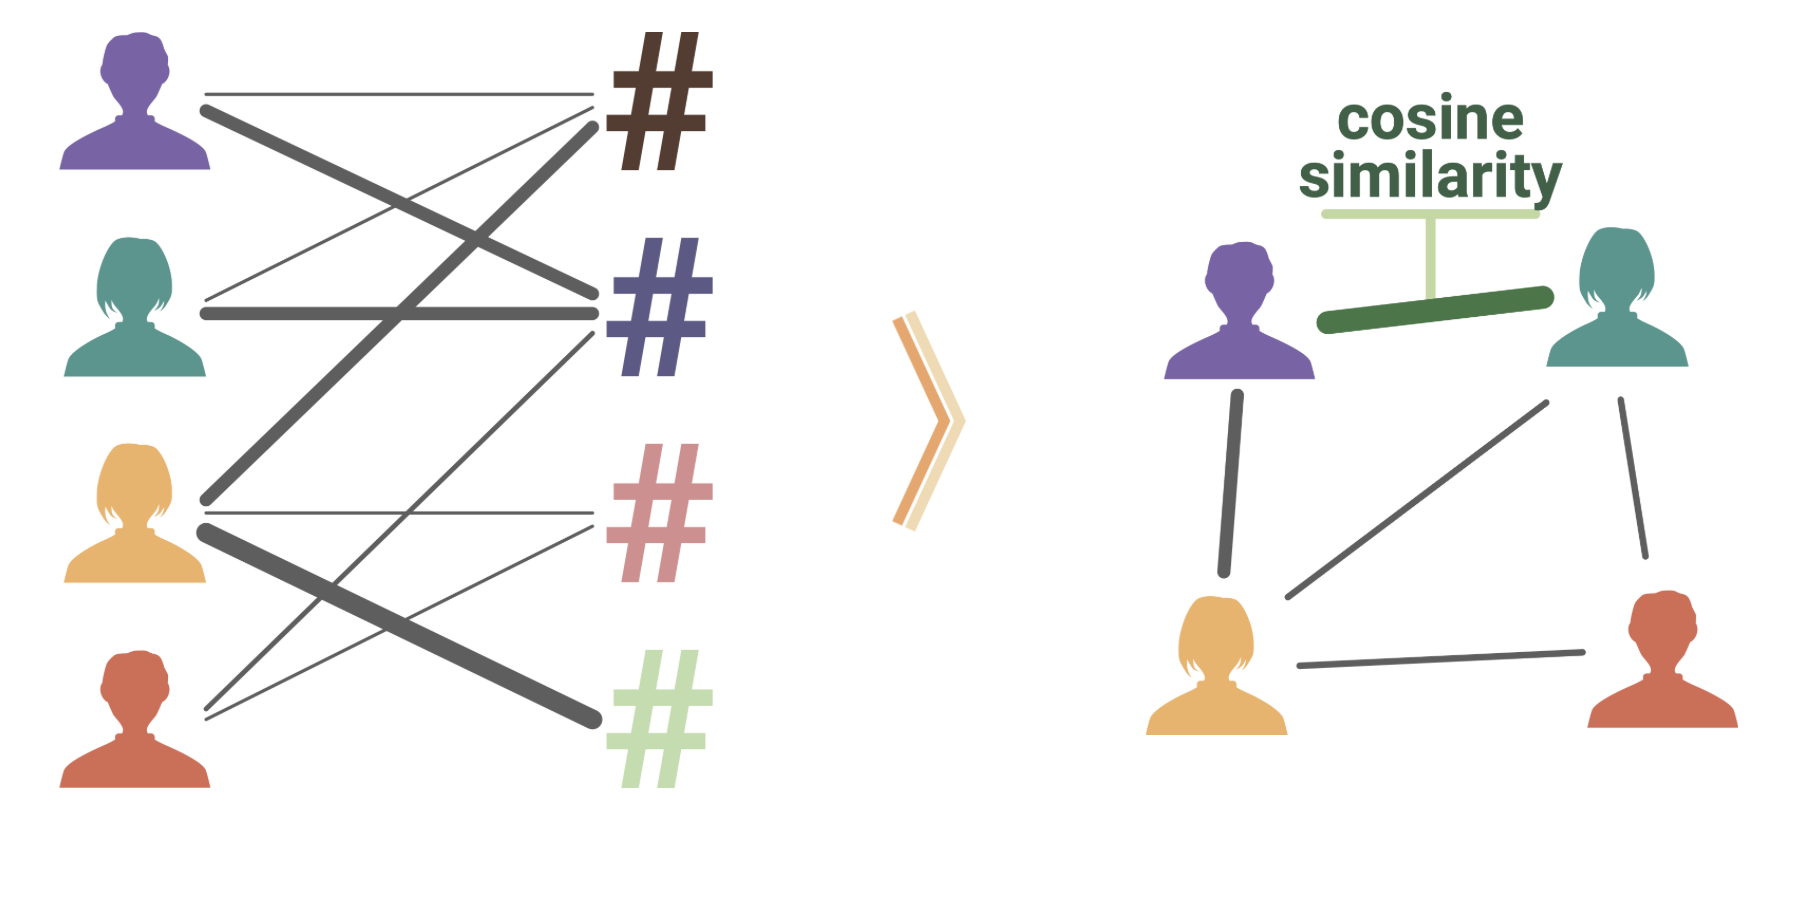

In [ ]:
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
from pathlib import Path
import gzip
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix
import igraph as ig
import xnetwork as xn

In [ ]:
datasetName = "debate2024_Jun_mastodon"
dataPath = Path("Data")
networksPath = dataPath/"Networks"
networksPath.mkdir(parents=True, exist_ok=True)
# Minimum number of activities for a user to be considered
minUserActivities = 5

In [ ]:
with gzip.open(dataPath / f"{datasetName}.feather.gz", 'rb') as f:
    df = pd.read_feather(f)

In [ ]:
userActivityCount = df["user_id"].value_counts()
usersWithMinActivities = set(userActivityCount[userActivityCount >= minUserActivities].index)
dfFiltered = df[df["user_id"].isin(usersWithMinActivities)]

In [ ]:
def obtainBipartiteEdgesHashtags(df,removeRetweets=True,removeReplies=False):
    if "hashtags" not in df or "post_type" not in df or "user_id" not in df:
        return []
    
    if(removeRetweets):
        df = df[df["post_type"] != "repost"]
    if(removeReplies):
        df = df[df["post_type"] != "reply"]

    # convert url strings that looks like lists to actual lists
    users = df["user_id"]
    hashtags = df["hashtags"].apply(lambda hashtagList: [hashtag.lower().strip() for hashtag in hashtagList])
    # keep only non-empty lists
    mask = hashtags.apply(lambda x: len(x) > 0)
    hashtags = hashtags[mask]
    users = users[mask]
    # create edges list users -> hashtags
    edges = [(user,hashtag) for user,hashtag_list in zip(users,hashtags) for hashtag in hashtag_list]
    return edges
  

In [ ]:
bipartiteEdges = obtainBipartiteEdgesHashtags(dfFiltered)

In [ ]:
def filterNodes(bipartiteEdges, minRightDegree=1, minLeftDegree=1):
    # goes from right to left
    bipartiteEdges = np.array(bipartiteEdges)
    mask = np.ones(len(bipartiteEdges),dtype=bool)
    if(minRightDegree>1):
        uniqueEdges = set(tuple(edge) for edge in bipartiteEdges)
        uniqueEdges = np.array(list(uniqueEdges))
        rightDegrees = Counter(uniqueEdges[:,1])
        mask &= np.array([rightDegrees[rightNode]>=minRightDegree for _,rightNode in bipartiteEdges])
    bipartiteEdges = bipartiteEdges[mask]
    
    # goes from left to right
    mask = np.ones(len(bipartiteEdges),dtype=bool)
    if(minLeftDegree>1):
        uniqueEdges = set(tuple(edge) for edge in bipartiteEdges)
        uniqueEdges = np.array(list(uniqueEdges))
        leftDegrees = Counter(uniqueEdges[:,0])
        mask &= np.array([leftDegrees[leftNode]>=minLeftDegree for leftNode,_ in bipartiteEdges])
    bipartiteEdges = bipartiteEdges[mask]
    return bipartiteEdges

In [ ]:
bipartiteEdges = filterNodes(bipartiteEdges, minRightDegree=4, minLeftDegree=4)

In [ ]:
bipartiteEdges = np.array(bipartiteEdges)
bipartiteIndexedEdges = np.zeros(bipartiteEdges.shape, dtype=int)
leftIndex2Label = [label for label in np.unique(bipartiteEdges[:,0])]
leftLabel2Index = {label: index for index, label in enumerate(leftIndex2Label)}
rightIndex2Label = [label for label in np.unique(bipartiteEdges[:,1])]
rightLabel2Index = {label: index for index, label in enumerate(rightIndex2Label)}

# create indexed edges in a numpy array integers
bipartiteIndexedEdges[:,0] = [leftLabel2Index[label] for label in bipartiteEdges[:,0]]
bipartiteIndexedEdges[:,1] = [rightLabel2Index[label] for label in bipartiteEdges[:,1]]

leftCount = len(leftIndex2Label)
rightCount = len(rightIndex2Label)

leftIndexedDegree = np.bincount(bipartiteIndexedEdges[:,0])
rightIndexedDegree = np.bincount(bipartiteIndexedEdges[:,1])


In [ ]:
bipartiteIndexedEdges[0:5]

In [ ]:
weightsMatrix = csr_matrix((np.ones(len(bipartiteIndexedEdges)), (bipartiteIndexedEdges[:,0], bipartiteIndexedEdges[:,1])), shape=(leftCount, rightCount))
vectorizer = TfidfTransformer()
weightsMatrix = vectorizer.fit_transform(weightsMatrix)


In [ ]:
similarities = cosine_similarity(weightsMatrix)

In [ ]:
# Apply a threshold to the similarities
threshold = 0.4
similarities[similarities<threshold] = 0
# remove diagonal
np.fill_diagonal(similarities, 0)

In [ ]:
g = ig.Graph.Weighted_Adjacency(similarities, mode="undirected", attr="weight")

In [ ]:
{
 "Number of nodes":g.vcount(),
 "Number of edges":g.ecount(),
 "Avg. degree": 2.0*g.ecount()/g.vcount()
 }

In [ ]:
g.vs["Label"] = leftIndex2Label
# original number of posts
g.vs["HashtagCount"] = leftIndexedDegree

In [ ]:
# get top hashtags of each user according to tfidf
topHashtags = []
topHashtagCount = 10
for row in weightsMatrix:
    topHashtags.append(", ".join([rightIndex2Label[index] for index in row.indices[np.argsort(row.data)][:-(topHashtagCount+1):-1]]))
g.vs["TopHashtags"] = topHashtags


Helper function to transfer properties form the dataframe to the network

In [ ]:
def transferColumnToNetwork(g,df,attributeName,combineMode="first",astype=None):
    if attributeName in df:
        dfGroup = df.groupby("user_id")[attributeName]
        dfGrouped = dfGroup.agg(combineMode)
        if(astype is not None):
            dfGrouped = dfGrouped.astype(astype)
        dfGrouped = dfGrouped[dfGrouped.index.isin(g.vs["Label"])]
        g.vs[attributeName] = [dfGrouped[label] for label in g.vs["Label"]]


In [ ]:
transferColumnToNetwork(g,df,"data_server")
transferColumnToNetwork(g,df,"data_account_followers_count","max")
transferColumnToNetwork(g,df,"data_account_following_count","max")
transferColumnToNetwork(g,df,"data_account_bot","max")
transferColumnToNetwork(g,df,"data_langs",pd.Series.mode,astype="str")

In [ ]:
# remove isolated nodes
gFiltered = g.subgraph(g.vs.select(_degree_gt=0))

In [ ]:
{
   "Number of nodes":gFiltered.vcount(),
   "Number of edges":gFiltered.ecount(),
   "Avg. degree": 2.0*gFiltered.ecount()/gFiltered.vcount()
}

In [ ]:
# save to XNET
xn.save(gFiltered, networksPath/f"{datasetName}_cohashtag.xnet")